In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

from sklearn.linear_model import LinearRegression
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


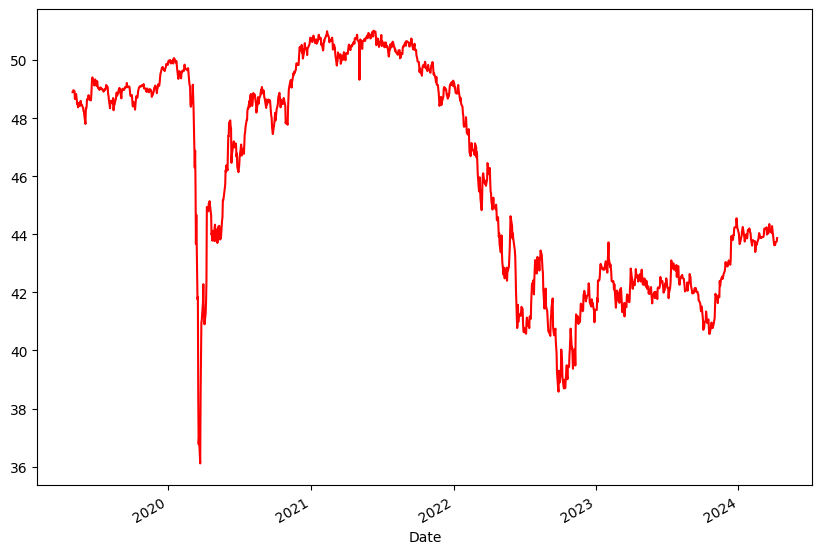

Linear Regression model
GHYG Price (y) = 1.29 * 3 Days Moving Average (x1)     + -0.30 * 9 Days Moving Average (x2)     + 0.43 (constant)


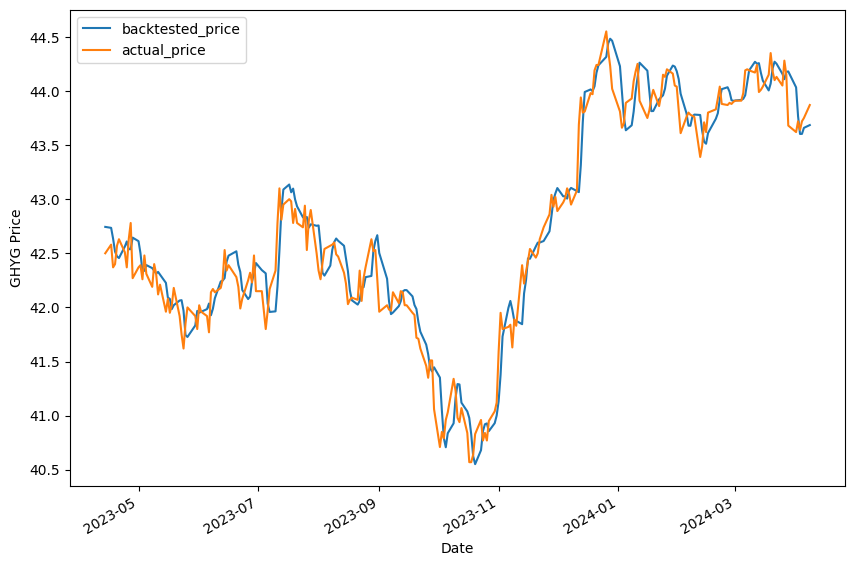

                price
Date                 
2023-04-14  42.743977
2023-04-17  42.735032
2023-04-18  42.635967
2023-04-19  42.515665
2023-04-20  42.471274
...               ...
2024-04-02  43.766585
2024-04-03  43.602524
2024-04-04  43.603362
2024-04-05  43.659125
2024-04-08  43.684750

[247 rows x 1 columns]


[*********************100%%**********************]  1 of 1 completed

                Close        S_3        S_9
Date                                       
2019-05-13  48.480000  48.670001  48.780000
2019-05-14  48.500000  48.603334  48.736667
2019-05-15  48.369999  48.449999  48.678889
2019-05-16  48.520000  48.463333  48.630000
2019-05-17  48.439999  48.443333  48.575556
...               ...        ...        ...
2024-04-03  43.720001  43.673333  43.990000
2024-04-04  43.639999  43.660000  43.930000
2024-04-05  43.720001  43.693334  43.887778
2024-04-08  43.750000  43.703334  43.845556
2024-04-09  43.869999  43.780000  43.825556

[1236 rows x 3 columns]



[*********************100%%**********************]  1 of 1 completed


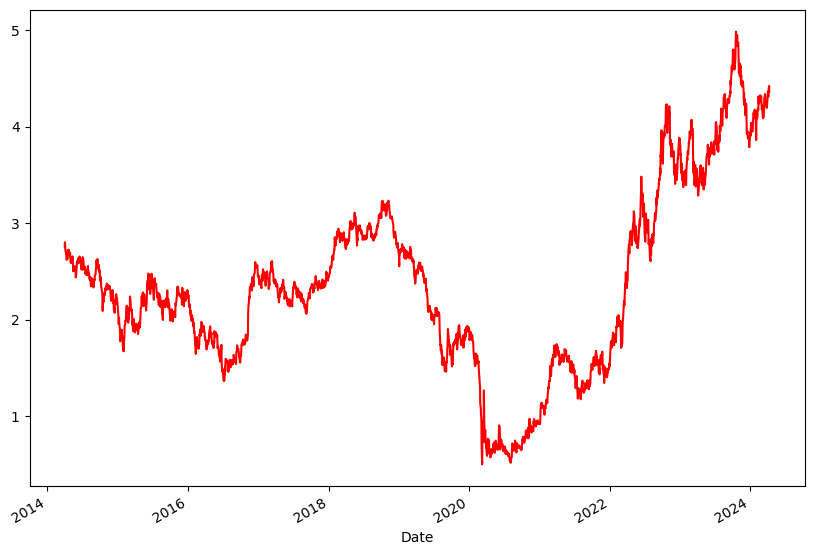

Linear Regression model
^TNX Price (y) = 1.20 * 3 Days Moving Average (x1)     + -0.20 * 9 Days Moving Average (x2)     + 0.01 (constant)


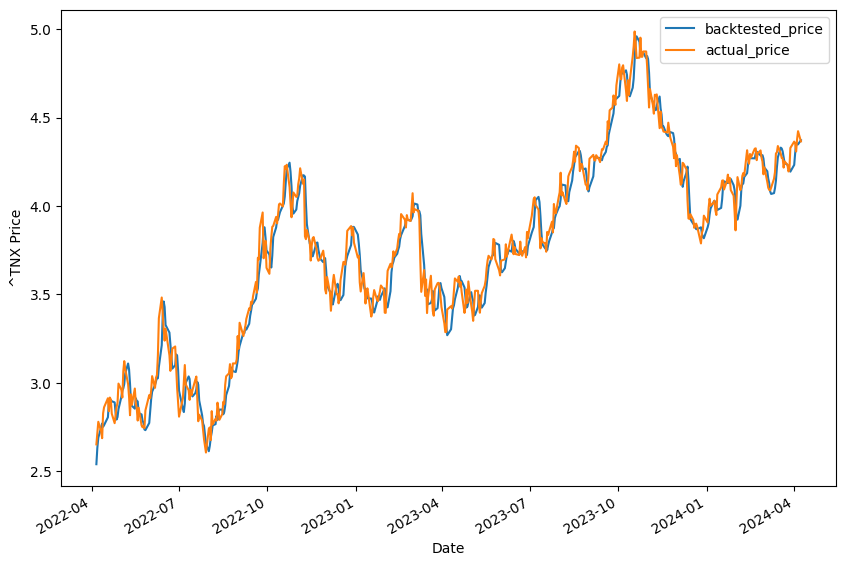

[*********************100%%**********************]  1 of 1 completed

               price
Date                
2022-04-06  2.539842
2022-04-07  2.632082
2022-04-08  2.689479
2022-04-11  2.749239
2022-04-12  2.770161
...              ...
2024-04-02  4.299052
2024-04-03  4.356706
2024-04-04  4.347869
2024-04-05  4.349474
2024-04-08  4.373191

[503 rows x 1 columns]
            Close       S_3       S_9
Date                                 
2014-04-11  2.619  2.643667  2.709444
2014-04-14  2.639  2.628667  2.696111
2014-04-15  2.628  2.628667  2.676667
2014-04-16  2.637  2.634667  2.659667
2014-04-17  2.721  2.662000  2.659111
...           ...       ...       ...
2024-04-03  4.355  4.349667  4.269667
2024-04-04  4.309  4.343000  4.273889
2024-04-05  4.378  4.347333  4.291667
2024-04-08  4.424  4.370333  4.310667
2024-04-09  4.366  4.389333  4.325333

[2513 rows x 3 columns]


In [2]:
products = ['GHYG','^TNX']

for product in products:
    if product == '^TNX':
        df = yf.download(product, '2014-04-01', '2024-04-10') # 10 years
    else: 
        df = yf.download(product, '2019-05-01', '2024-04-10') # 5 years
    df = df[['Close']]

    # only keep closing price
    df = df.dropna()
    df.Close.plot(figsize=(10, 7),color='r')
    plt.show()
    
    # train: use moving averages over last 3 days and 9 days 
    df['S_3'] = df['Close'].rolling(window=3).mean()
    df['S_9'] = df['Close'].rolling(window=9).mean()
    df['next_day_price'] = df['Close'].shift(-1)

    df = df.dropna()
    x = df[['S_3', 'S_9']]

    y = df['next_day_price']

    # separate testing and training data
    index = int(0.8*(len(df)))
    x_train, x_test, y_train, y_test = x[:index], x[index:], y[:index], y[index:]

    # train linear regression
    linear = LinearRegression().fit(x_train, y_train)

    print("Linear Regression model")
    print(f"{product} Price (y) = %.2f * 3 Days Moving Average (x1) \
    + %.2f * 9 Days Moving Average (x2) \
    + %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))
    
    # backtest
    backtest_price = linear.predict(x_test)
    backtest_price = pd.DataFrame(
        backtest_price, index=y_test.index, columns=['price'])
    backtest_price.plot(figsize=(10, 7))
    y_test.plot()
    plt.legend(['backtested_price', 'actual_price'])
    plt.ylabel(f"{product} Price")
    plt.show()

    print(backtest_price)
    # export to excel
    export_df = pd.DataFrame({
        'dates': x_test.index, 
        'Historical Price': y_test,
        'Model Predicted Price': backtest_price['price']  
    })

    # Export the DataFrame to an Excel file
    # export_df.to_excel(f"{product}_backtest_results.xlsx", index=False)
    
    # predict next 3 months
    if product == '^TNX':
        predict_df = yf.download(product, '2014-04-01', '2024-04-10') # 10 years
    else: 
        predict_df = yf.download(product, '2019-05-01', '2024-04-10') # 5 years
    predict_df = predict_df[['Close']]
    predict_df = predict_df[['Close']]
    predict_df = predict_df.dropna()
    predict_df['S_3'] = predict_df['Close'].rolling(window=3).mean()
    predict_df['S_9'] = predict_df['Close'].rolling(window=9).mean()
    predict_df = predict_df.dropna()
    print(predict_df)
    current_date = predict_df.index[-1]
    end_date = datetime(2024, 7, 31)

    while current_date <= end_date:
        # forecast the price
        predict_df['predicted_price'] = linear.predict(predict_df[['S_3', 'S_9']])
        last_row = predict_df.tail(1)
        predicted_price = last_row['predicted_price'].iloc[-1]

        last_date = predict_df.index[-1]
        new_date = last_date + timedelta(days=1)
        current_date = new_date
        new_row = pd.DataFrame(index=[new_date], columns=predict_df.columns)
        new_row['Close'] = predicted_price
        moving_avg_list = predict_df['Close'].iloc[-8:].tolist()
        moving_avg_list.append(predicted_price)
        new_row['S_3'] = sum(moving_avg_list[-3:]) / 3
        new_row['S_9'] = sum(moving_avg_list) / 9
        warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")
        predict_df = pd.concat([predict_df, new_row])   
        # print("after adding new row")
        # print(df)

    # adjust to only weekly data 
    predict_df = predict_df.resample('W-FRI').last() # only weekly data 
    # export to excel
    export_df = pd.DataFrame({
        'Dates': predict_df.index, 
        'Historical Price': predict_df['Close'], 
        'Base': predict_df['predicted_price'],
    })

    # Export the DataFrame to an Excel file
    export_df.to_excel(f"{product}_predicted_results_double.xlsx", index=False)